# Description

In this notebook, we will build the **Machine Translation** from English to Vietnamese

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:   print(e)

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import string
import nltk
from sklearn.model_selection import train_test_split

from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset
import tensorflow_text as tf_text

from read_file_utils import *
from model_utils import *

2024-07-29 09:51:12.261840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 09:51:12.261855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 09:51:12.262503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
PATH_EN_FILE = r"data/processed_data/en_sent.txt"
PATH_VI_FILE = r"data/processed_data/vi_sent.txt"

PATH_TOKENIZER = r"data/tokeninzer_en_vi_converter"

MAX_TOKENS=128

# 1. Data handling

- First, we need to download the dataset.

In [3]:
list_en_sentence = read_text_file(PATH_EN_FILE)
list_en_sentence = np.array(list_en_sentence)
list_vi_sentence = read_text_file(PATH_VI_FILE)
list_vi_sentence = np.array(list_vi_sentence)

assert len(list_en_sentence) == len(list_vi_sentence)
print(f"Number of pair sentence: {len(list_en_sentence)}")

Number of pair sentence: 3265005


In [4]:
list_en_sentence_train, list_en_sentence_val, list_vi_sentence_train, list_vi_sentence_val =\
    train_test_split(list_en_sentence, list_vi_sentence, test_size=0.2, random_state=42)

print(f"Number of training sample: {len(list_en_sentence_train)}")
print(f"Number of validation sample: {len(list_en_sentence_val)}")

Number of training sample: 2612004
Number of validation sample: 653001


In [5]:
train_examples = tf.data.Dataset.from_tensor_slices((list_en_sentence_train, list_vi_sentence_train))
val_examples = tf.data.Dataset.from_tensor_slices((list_en_sentence_val, list_vi_sentence_val))

In [6]:
for en_examples, vi_examples in train_examples.batch(3).take(1):
    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))
    print()

    print('> Examples in Vietnamese:')
    for vi in vi_examples.numpy():
        print(vi.decode('utf-8'))

> Examples in English:
celiac disease peptic ulcers stomach cancer gallstones small bowel bacterial overgrowth severe indigestion may be an indicator of a serious underlying condition .
rice helps to improve the rate of rehydration and decrease the length of illness .
what have we got on the other side ?

> Examples in Vietnamese:
bệnh celiac loét dạ dày ung thư dạ dày sỏi mật vi khuẩn phát triển quá mức trong ruột non chứng khó tiêu nghiêm trọng có thể là dấu hiệu của bệnh lý nghiêm trọng tiềm ẩn .
cơm giúp cải thiện tỷ lệ mất nước và giảm thời gian bị ốm .
và bên kia thì chúng ta có gì ?


## 1.1. Load tokenizer

- We load the pre-train Tokenizer and test it. 

In [7]:
tokenizers = tf.saved_model.load(PATH_TOKENIZER)

In [8]:
encoded = tokenizers.vi.tokenize(vi_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 1201, 16054, 3429, 2508, 2215, 1999, 1371, 2508, 2215, 3455, 1637, 1387, 2000, 1110, 1315, 1126, 1449, 991, 2598, 3023, 1245, 1336, 1250, 1776, 1192, 983, 994, 984, 1559, 1217, 985, 1201, 1127, 1776, 1192, 2266, 2008, 17, 3]
[2, 3121, 1120, 1660, 1724, 1800, 1648, 1275, 1082, 982, 1304, 1084, 1147, 1033, 2863, 17, 3]
[2, 982, 1209, 1602, 1087, 1001, 1003, 983, 1019, 34, 3]


- The `detokenize` method can convert these tokens index back to original text 

In [9]:
list_original_sentence = tokenizers.vi.detokenize(encoded)

for original_sentence in list_original_sentence.numpy():
    print(original_sentence.decode('utf-8'))

bệnh celiac loét dạ dày ung thư dạ dày sỏi mật vi khuẩn phát triển quá mức trong ruột non chứng khó tiêu nghiêm trọng có thể là dấu hiệu của bệnh lý nghiêm trọng tiềm ẩn .
cơm giúp cải thiện tỷ lệ mất nước và giảm thời gian bị ốm .
và bên kia thì chúng ta có gì ?


## 1.2. Set up data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training.

- It tokenizes them into ragged batches.
- It trims each to be no longer than MAX_TOKENS.
- It splits the target (Vietnamese) tokens into inputs and labels. These are shifted by one step so that at each input location the label is the id of the next token.
- It converts the RaggedTensors to padded dense Tensors.
- It returns an (inputs, labels) pair.

In [10]:
def prepare_batch(en, vi):
    """
    This function take pair of en and vi. Then return suitable format for training
    """

    en = tokenizers.en.tokenize(en)      # Output is ragged.
    en = en[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    en = en.to_tensor()  # Convert to 0-padded dense Tensor

    vi = tokenizers.vi.tokenize(vi)
    vi = vi[:, :(MAX_TOKENS+1)]
    vi_inputs = vi[:, :-1].to_tensor()  # Drop the [END] tokens
    vi_labels = vi[:, 1:].to_tensor()   # Drop the [START] tokens

    return (en, vi_inputs), vi_labels

In [11]:
BUFFER_SIZE = 20000
BATCH_SIZE = 128

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [12]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [13]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(128, 62)
(128, 70)
(128, 70)


# 2. Define component

In [14]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

tf.keras.backend.clear_session()
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.vi.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

- We can test the output shape of Transformer model.
- Then, we can test the output shape of the attention score, which has shape `(batch, heads, target_seq, input_seq)`

In [15]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(128, 70)
(128, 62)
(128, 70, 45463)


In [16]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(128, 8, 70, 62)


In [17]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  12094336  
                                                                 
 decoder (Decoder)           multiple                  10569088  
                                                                 
 dense_16 (Dense)            multiple                  5864727   
                                                                 
Total params: 28528151 (108.83 MB)
Trainable params: 28528151 (108.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 3. Training

## 3.1. Custom optimizer

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## 3.2. Loss and metrics

- Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. 
- In other word, we will remove the padding 0 when calculating the mask. That mean the padding 0 will not affect the loss value.

In [19]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## 3.3. Training

In [20]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [21]:
EPOCHS = 5
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/5


I0000 00:00:1722261101.583193 1177832 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20407/20407 [==============================] - 2787s 136ms/step - loss: 2.9223 - masked_accuracy: 0.5080 - val_loss: 2.0646 - val_masked_accuracy: 0.6210
Epoch 2/5
20407/20407 [==============================] - 2763s 135ms/step - loss: 2.0942 - masked_accuracy: 0.6126 - val_loss: 1.9087 - val_masked_accuracy: 0.6430
Epoch 3/5
20407/20407 [==============================] - 2760s 135ms/step - loss: 1.9724 - masked_accuracy: 0.6293 - val_loss: 1.8376 - val_masked_accuracy: 0.6518
Epoch 4/5
20407/20407 [==============================] - 2759s 135ms/step - loss: 1.9111 - masked_accuracy: 0.6378 - val_loss: 1.8044 - val_masked_accuracy: 0.6572
Epoch 5/5
20407/20407 [==============================] - 2765s 136ms/step - loss: 1.8748 - masked_accuracy: 0.6432 - val_loss: 1.7872 - val_masked_accuracy: 0.6601


# 4. Inference

The following steps are used for inference:
- Encode the input sentence using the Vietnamese tokenizer (tokenizers.pt). This is the encoder input.
- The decoder input is initialized to the [START] token.
- Calculate the padding masks and the look ahead masks.
- The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
- Concatenate the predicted token to the decoder input and pass it to the decoder **AGAIN**.
- The process will stop until we get the [END] token or reach the maximum number of token.

In [22]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    # The input sentence is English, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.en.tokenize(sentence).to_tensor()
    encoder_input = sentence

    # As the output language is Vietnamese, initialize the output with the `[START]` token.
    start_end = self.tokenizers.vi.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # Define the output_array with [START] token
    # `tf.TensorArray` is required here, so that the dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack()) # Shape (1, tokens)
    
    # We get the predicted output and corresponding token
    text = tokenizers.vi.detokenize(output)[0]  # Shape: `()`.
    tokens = tokenizers.vi.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [23]:
translator = Translator(tokenizers, transformer)

In [24]:
sentence = 'i love you.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print(translated_text.numpy().decode('utf-8'))

tôi yêu bạn


# 5. Attention plots

- To increase the interpretable of the model, we create attention heatmaps you can use to visualize the internal working of the model.

In [25]:
sentence = 'Tran Luu Quang (born August 30, 1967) is a Vietnamese politician. A member of the 13th Central Committee of the Communist Party, he is currently one of the four Deputy Prime Ministers of Vietnam'
sentence = sentence.lower()

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print(translated_text.numpy().decode('utf-8'))

trần lưu quảng ( sinh ngày 30 tháng 8 năm 1967 ) là một chính trị gia người việt nam . một thành viên của uỷ ban trung ương thứ 13 của đảng cộng sản , hiện là một trong bốn bộ trưởng thủ tướng của việt nam


In [26]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.en.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.en.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(41,), dtype=string, numpy=
array([b'[START]', b'tran', b'luu', b'quang', b'(', b'born', b'august',
       b'30', b',', b'1967', b')', b'is', b'a', b'vietnamese',
       b'politician', b'.', b'a', b'member', b'of', b'the', b'13th',
       b'central', b'committee', b'of', b'the', b'communist', b'party',
       b',', b'he', b'is', b'currently', b'one', b'of', b'the', b'four',
       b'deputy', b'prime', b'ministers', b'of', b'vietnam', b'[END]'],
      dtype=object)>

- We will get the `attention_weights` of first head

In [27]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    cax = ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)
    plt.colorbar(cax)


def plot_attention_weights(in_tokens, translated_tokens, attention_heads):
    """
    This function visualize the attention scores between in_tokens and translated_tokens

    * Parameter
    in_tokens -- array of tokens
    translated_tokens -- array of tokens
    attention_heads -- shape (# heads, len_translated_tokens, len_in_tokens)
    """

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

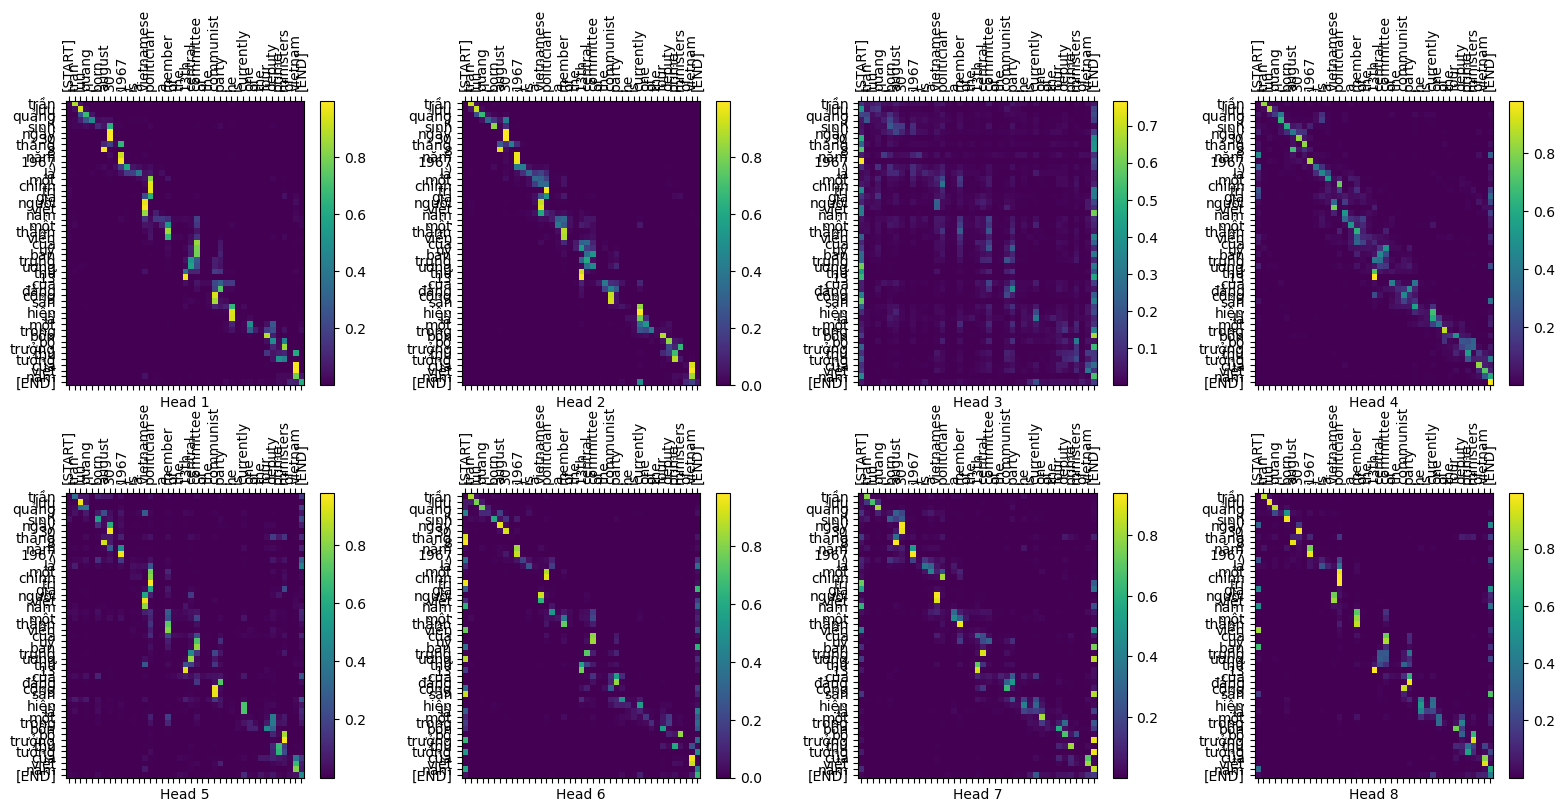

In [28]:
plot_attention_weights(in_tokens,
                       translated_tokens,
                       attention_weights[0])

- We can calculate average of all attention heads.

In [29]:
average_attention_weights = attention_weights[0].numpy()
average_attention_weights = average_attention_weights.mean(axis=0)

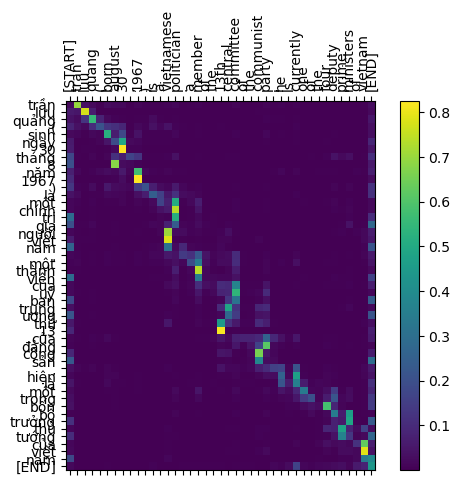

In [30]:
plot_attention_head(in_tokens, translated_tokens, average_attention_weights)

In [31]:
def visualize_sentence_mapping(in_tokens, translated_tokens, heat_map, threshold=0.4):
    """
    Visualizes the mapping from English to Vietnamese sentences based on a heat map.

    Parameters:
    heat_map (numpy.ndarray): 2D array representing relationship strengths between sentences.
    in_tokens (list): List of English sentences.
    translated_tokens (list): List of Vietnamese sentences.
    """
    translated_tokens = translated_tokens[1:]

    print(f"in_tokens: {in_tokens.shape}")
    print(f"translated_tokens: {translated_tokens.shape}")
    print(f"heat_map: {heat_map.shape}")

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 3))

    # Create a table of sentences
    table_data = []
    for i in range(len(translated_tokens)):
        for j in range(len(in_tokens)):
            if heat_map[i, j] > threshold:
                table_data.append((translated_tokens[i].decode('utf-8'), in_tokens[j].decode('utf-8')))

    # Create table and add it to the plot
    table = ax.table(cellText=table_data, colLabels=["English", "Vietnamese"], cellLoc='center', loc='center')

    table.set_fontsize(12)
    ax.set_title("Mapping from English to Vietnamese Sentences")
    plt.show()

in_tokens: (41,)
translated_tokens: (49,)
heat_map: (49, 41)


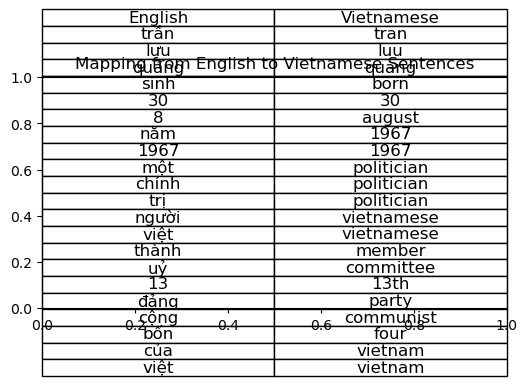

In [32]:
visualize_sentence_mapping(in_tokens.numpy(), translated_tokens.numpy(), average_attention_weights, threshold=0.5)

# 6. Export the model

Next, we can save the model into `tf.saved_model` to use it later.

In [33]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result, tokens, attention_weights

In [34]:
translator_export = ExportTranslator(translator)

In [35]:
tf.saved_model.save(translator_export, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


We can load back the saved translator to make sure it work correctly.

In [36]:
reloaded = tf.saved_model.load('translator')

In [43]:
translated_text, translated_tokens, attention_weights = reloaded('i love cake, because it is sweet.')
print(translated_text.numpy().decode('utf-8'))

tôi yêu bánh , vì nó ngọt ngào .
